In [ ]:
################################################################################
######################  Lending Tree Loan Status  ##############################
######################      Classification        ##############################
######################       Linear SVM           ##############################
######################         HPO GPU            ##############################
################################################################################

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/LoanStatus/ML/RAPIDS/

/content/drive/MyDrive/LoanStatus/ML/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [22.8 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Pac

In [3]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


In [3]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [4]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [5]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
import os
import random
import time
from contextlib import contextmanager
import dask
import dask_optuna
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait, performance_report
import joblib
from joblib import parallel_backend
import numpy as np
import cupy as cp
import cudf
import cuml
from cuml.model_selection import train_test_split
from cuml.svm import LinearSVC
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import pickle
import pandas as pd
import warnings
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

my_dpi=96

print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 6.9 MB/s 
     |████████████████████████████████| 81 kB 8.5 MB/s 
     |████████████████████████████████| 209 kB 63.2 MB/s 
     |████████████████████████████████| 1.6 MB 40.9 MB/s 
     |████████████████████████████████| 150 kB 57.0 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 40.1 MB/s 
     |████████████████████████████████| 146 kB 38.2 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=623b66604bad90d44dc6d85c80068063a6625e3b32516a3d6d469a0249b2c618
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [6]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [7]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

<Client: 'tcp://172.28.0.2:43695' processes=1 threads=1, memory=25.46 GiB>

In [8]:
# Set seed 
seed_value = 42
os.environ['LinearSVC_GPU'] = str(seed_value)
cp.random.seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [9]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [10]:
# Read data
trainDF = cudf.read_csv('trainDF_SMOTE.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF  = cudf.read_csv('testDF_SMOTE.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

Train set: Number of rows and columns: (3022132, 51)
Test set: Number of rows and columns: (432473, 51)


In [11]:
# Find categorical variables
cat_cols = list(trainDF.select_dtypes('object').columns)
cat_cols1 = list(testDF.select_dtypes('object').columns)

# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [99]:
################################################################################
######################         F1 Weighted        ##############################
######################         100 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_linearSVC_optuna_SMOTE_100_weightedF1_tpe'

In [100]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [101]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l2', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: F1 weighted of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LinearSVC(penalty=penalty, 
                   loss=loss, 
                   penalized_intercept=penalized_intercept, 
                   max_iter=max_iter, 
                   linesearch_max_iter=linesearch_max_iter, 
                   lbfgs_memory=lbfgs_memory, 
                   C=C, 
                   grad_tol=grad_tol, 
                   change_tol=change_tol,  
                   verbose=False)  
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = f1_score(y_test.to_numpy(), y_pred.to_numpy(), average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [102]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

[W] [21:42:35.660712] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.4295027409998511
- Trial weighted F1: 0.8147946302801139
######################################################
Score with default parameters :  0.8147946302801139


In [103]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)

    return score

In [104]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.pkl'): 
      study = joblib.load('LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-06-28 21:42:35.904221
[W] [21:42:36.223461] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.40333217599982163
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 1.252699340000163
- Trial weighted F1: 0.9466162300856525
######################################################
- Trial time: 1.1922568959998898
- Trial weighted F1: 0.809819534850727
######################################################
- Trial time: 1.2956400600000961
- Trial weighted F1: 0.9168845657071173
######################################################
- Trial time: 1.769501470999785
- Trial weighted F1: 0.9169563512494147
######################################################
- Trial time: 1.3460192809998262
- Trial weighted F1: 0.917019740061296
######################################################
[W] [21:42:44.271337] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial

In [105]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions


In [106]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol':'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol':'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory':'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_loss':'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept':'penalized_intercept'}, inplace=True)
trials_df.rename(columns={'params_penalty':'penatly'}, inplace=True)

trials_df = trials_df.sort_values('f1_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.csv', index=False)

    iteration  f1_weighted             datetime_start  \
98         98     0.960045 2022-06-28 21:47:11.747797   
97         97     0.960045 2022-06-28 21:46:51.248450   
99         99     0.958921 2022-06-28 21:47:32.045391   
94         94     0.958039 2022-06-28 21:45:35.252464   
96         96     0.957740 2022-06-28 21:46:34.860978   
..        ...          ...                        ...   
69         69     0.814795 2022-06-28 21:44:15.668381   
14         14     0.809820 2022-06-28 21:42:52.821627   
36         36     0.809820 2022-06-28 21:43:24.572736   
2           2     0.809820 2022-06-28 21:42:37.853009   
59         59     0.809820 2022-06-28 21:44:00.031310   

            datetime_complete               duration    C  change_tol  \
98 2022-06-28 21:47:32.045225 0 days 00:00:20.297428  0.3    0.000011   
97 2022-06-28 21:47:11.747599 0 days 00:00:20.499149  0.3    0.000016   
99 2022-06-28 21:47:49.929412 0 days 00:00:17.884021  0.3    0.000039   
94 2022-06-28 21:45:52.

In [107]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations


In [108]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [109]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [110]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [111]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

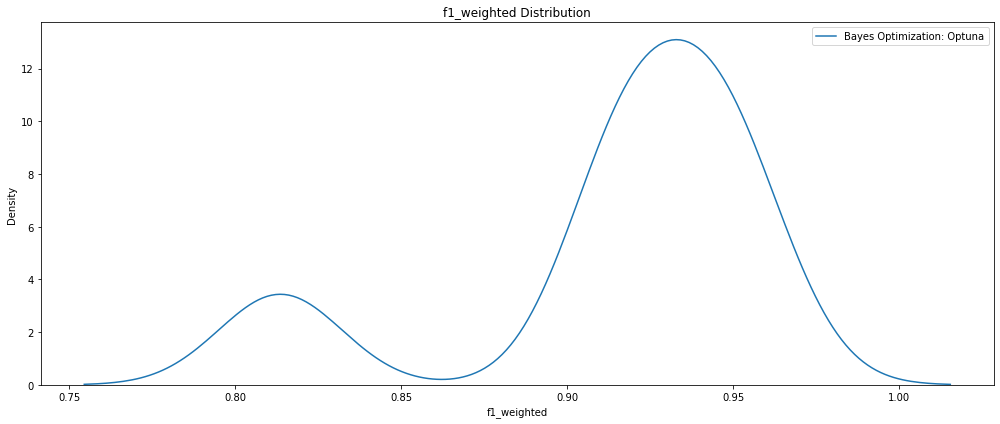

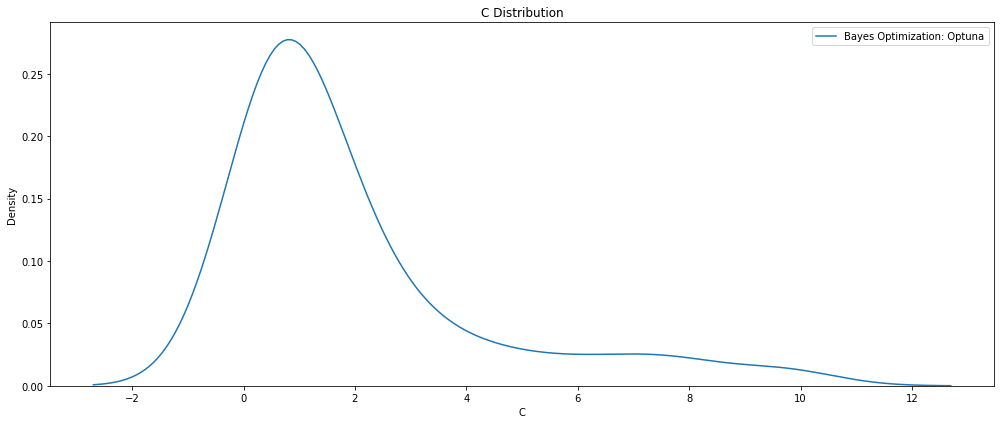

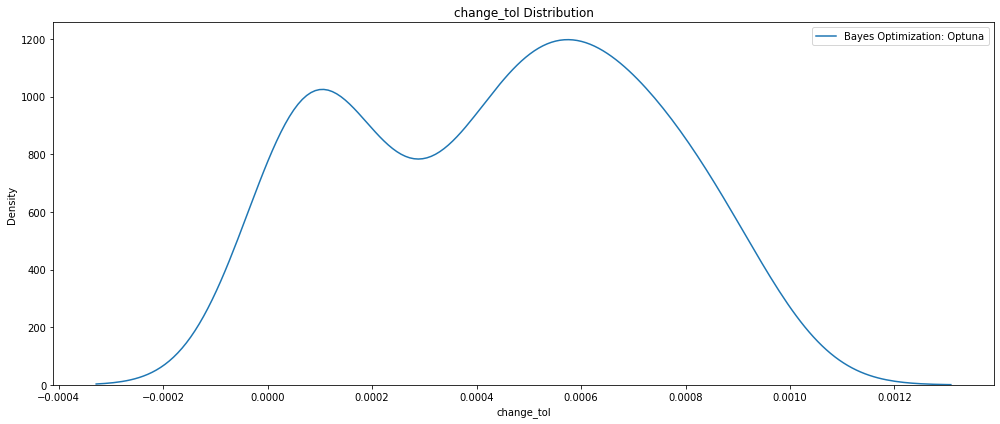

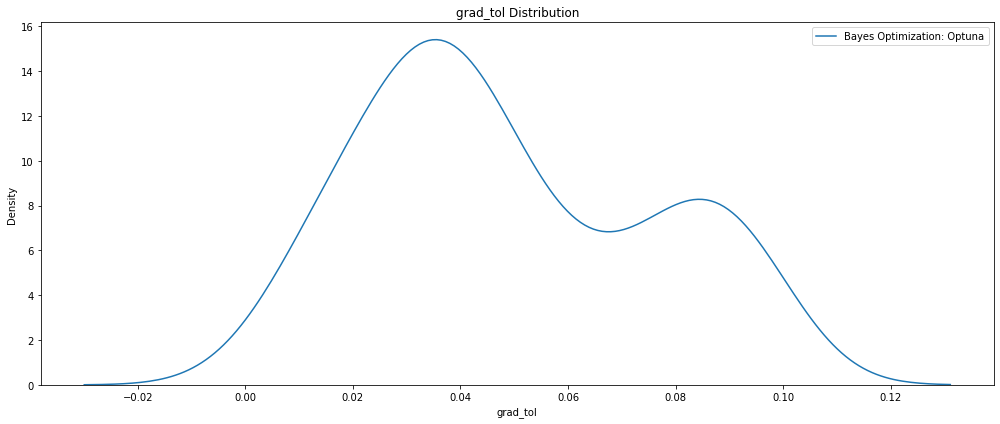

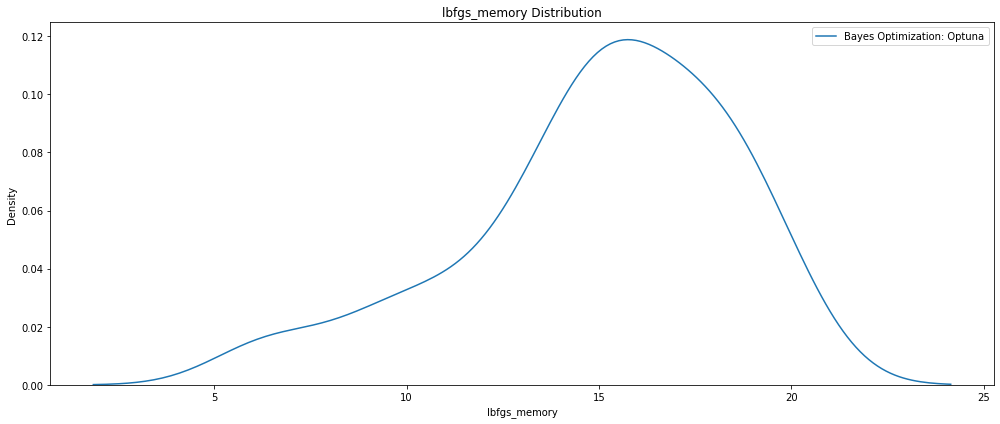

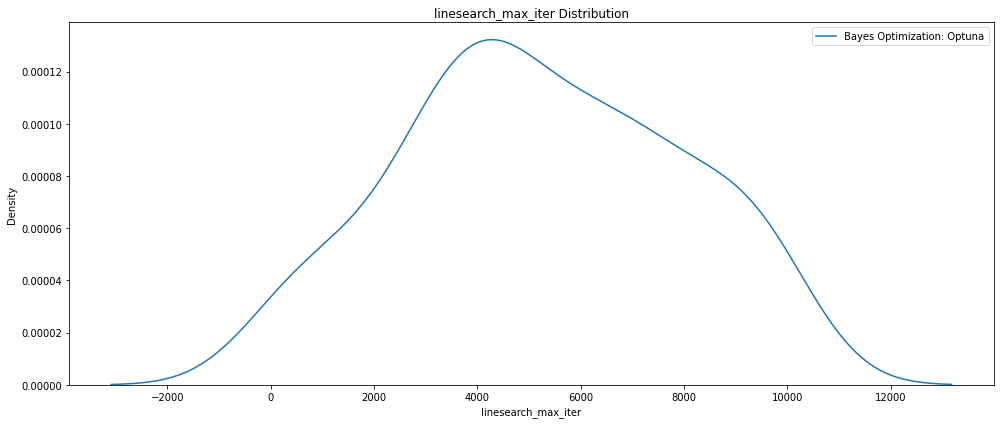

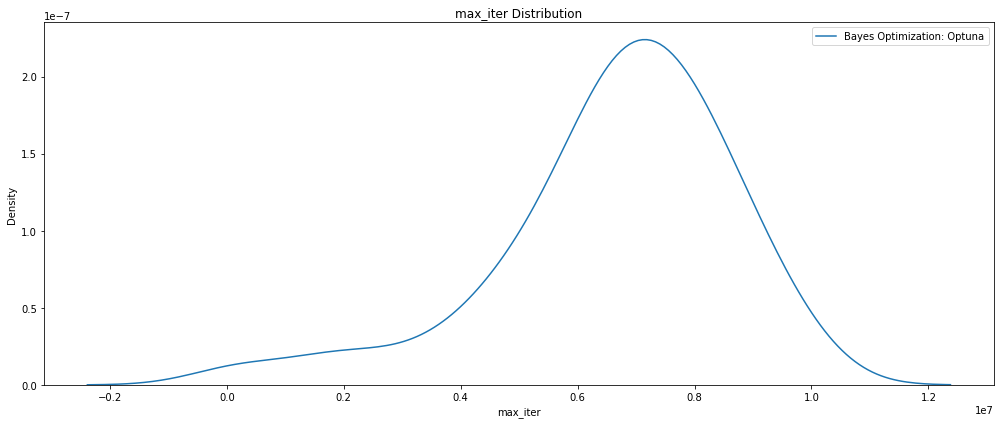

In [112]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

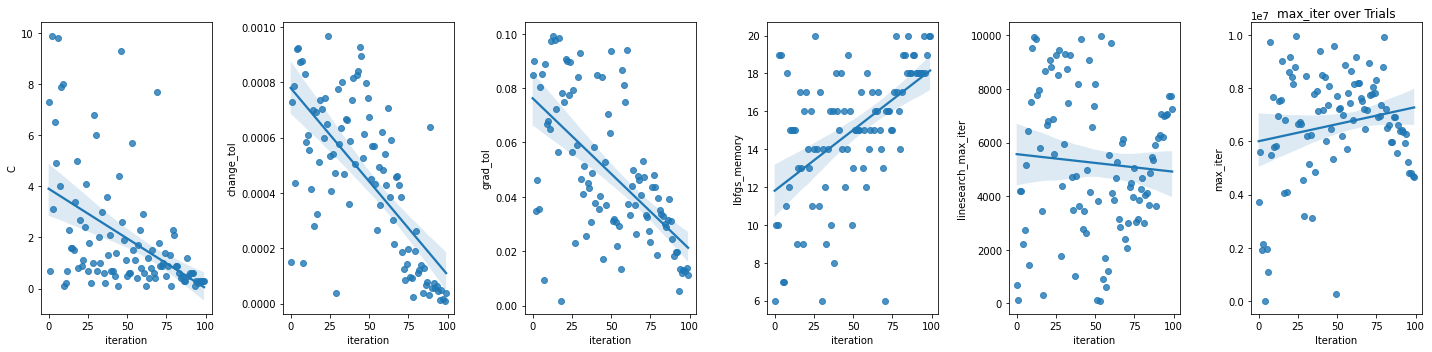

In [113]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 6, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [114]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [115]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [116]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 0.30000000000000004,
 'change_tol': 1.5571253843605563e-05,
 'grad_tol': 0.012580609689127427,
 'lbfgs_memory': 19,
 'linesearch_max_iter': 7740,
 'loss': 'hinge',
 'max_iter': 4809613,
 'penalized_intercept': 'False',
 'penalty': 'l1'}

In [117]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [118]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [119]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [120]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [121]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_SMOTE_trials100_GPU_weightedF1.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_SMOTE_trials100_GPU_weightedF1.pkl')
# print(model)
# =============================================================================

In [122]:
print('\nModel Metrics for LinearSVC HPO SMOTE 100trials GPU')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO SMOTE 100trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.85      0.84      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.91      0.91      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[369403   8445]
 [  8559  46066]]


Accuracy score : 0.961
Precision score : 0.845
Recall score : 0.843
F1 score : 0.844


In [123]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 GPU trials optimization scores 0.91048 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      98
f1_weighted                              0.960045
datetime_start         2022-06-28 21:47:11.747797
datetime_complete      2022-06-28 21:47:32.045225
duration                   0 days 00:00:20.297428
C                                             0.3
change_tol                               0.000011
grad_tol                                 0.013727
lbfgs_memory                                   20
linesearch_max_iter                          7718
loss                                        hinge
max_iter                                  4700874
penalized_intercept                         False
penatly                                        l1
state                                    COMPLETE
Name: 98, dtype: object


In [ ]:
################################################################################
######################        Weighted ROC        ##############################
######################         100 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_linearSVC_optuna_SMOTE_100_weightedROC_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted ROC of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')
    
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LinearSVC(penalty=penalty, 
                   loss=loss, 
                   penalized_intercept=penalized_intercept, 
                   max_iter=max_iter, 
                   linesearch_max_iter=linesearch_max_iter, 
                   lbfgs_memory=lbfgs_memory, 
                   C=C, 
                   grad_tol=grad_tol, 
                   change_tol=change_tol,  
                   verbose=False)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test.to_numpy(), y_pred.to_numpy(), 
                          average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 3.7583757800000512
- Trial weighted ROC: 0.836305949211013
######################################################
Score with default parameters :  0.836305949211013


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.pkl'): 
      study = joblib.load('LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-28 21:09:48.367874
[W] [21:09:48.670514] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.29449270399982197
- Trial weighted ROC: 0.5
######################################################
[W] [21:09:49.105935] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.2949012030001086
- Trial weighted ROC: 0.5
######################################################
[W] [21:09:49.547564] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.2952220969998507
- Trial weighted ROC: 0.5
######################################################
- Trial time: 1.1224204590000681
- Trial weighted ROC: 0.8391623198935539
######################################################
[W] [21:09:51.274906] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.29676064000000224
- Trial weighted ROC: 0.5
######################################################
[W] [

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol':'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol':'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory':'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_loss':'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept':'penalized_intercept'}, inplace=True)
trials_df.rename(columns={'params_penalty':'penatly'}, inplace=True)

trials_df = trials_df.sort_values('roc_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.csv', index=False)

    iteration  roc_weighted             datetime_start  \
10         10      0.910482 2022-06-28 21:09:54.517042   
92         92      0.908421 2022-06-28 21:12:07.143087   
13         13      0.908421 2022-06-28 21:10:18.058757   
88         88      0.908421 2022-06-28 21:12:02.597951   
87         87      0.908421 2022-06-28 21:12:01.331498   
..        ...           ...                        ...   
77         77      0.500000 2022-06-28 21:11:48.082075   
1           1      0.500000 2022-06-28 21:09:48.808614   
58         58      0.500000 2022-06-28 21:11:23.280849   
0           0      0.500000 2022-06-28 21:09:48.371995   
99         99           NaN 2022-06-28 21:12:17.176990   

            datetime_complete               duration    C  change_tol  \
10 2022-06-28 21:10:15.364152 0 days 00:00:20.847110  0.3    0.000016   
92 2022-06-28 21:12:08.423211 0 days 00:00:01.280124  0.3    0.000754   
13 2022-06-28 21:10:19.313031 0 days 00:00:01.254274  0.3    0.000248   
88 2022-06-

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_LinearSVC_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

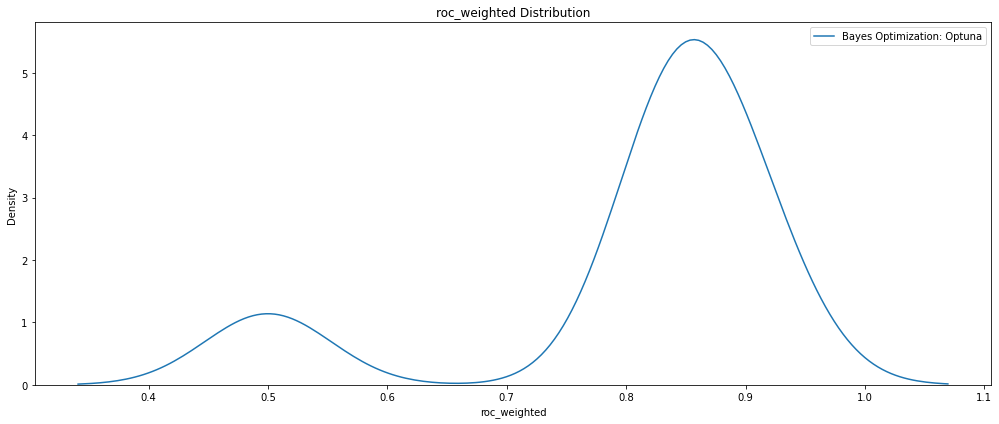

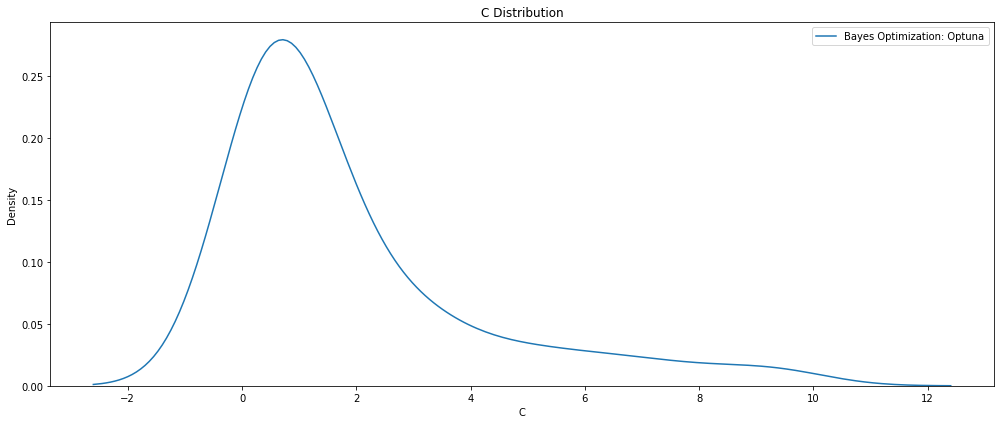

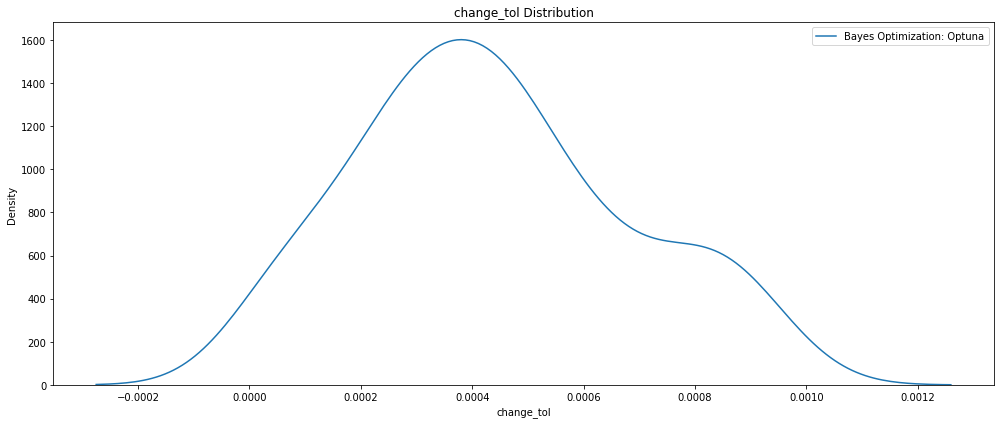

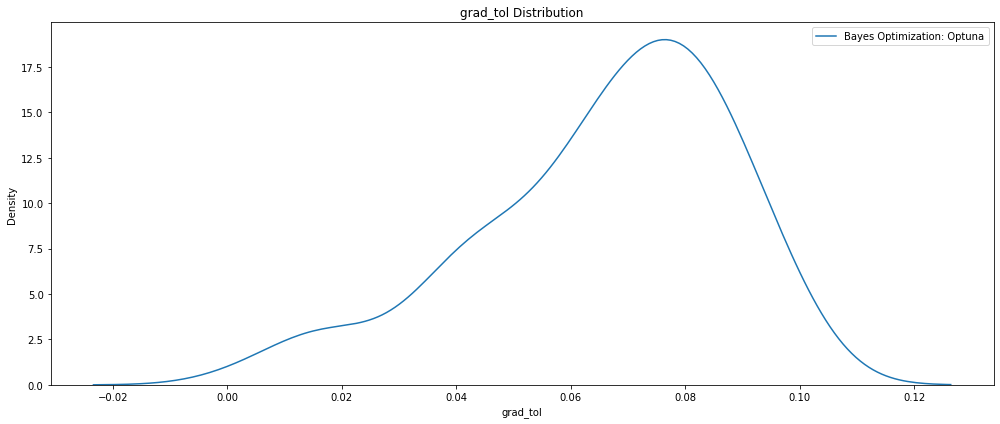

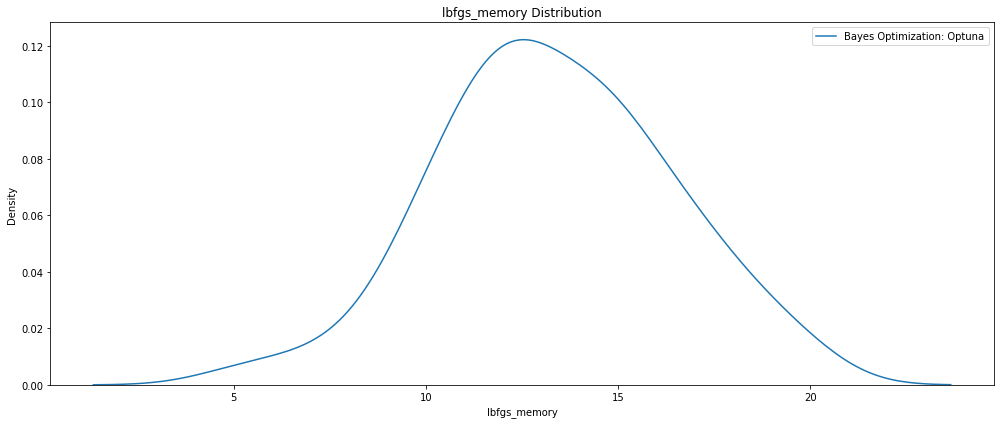

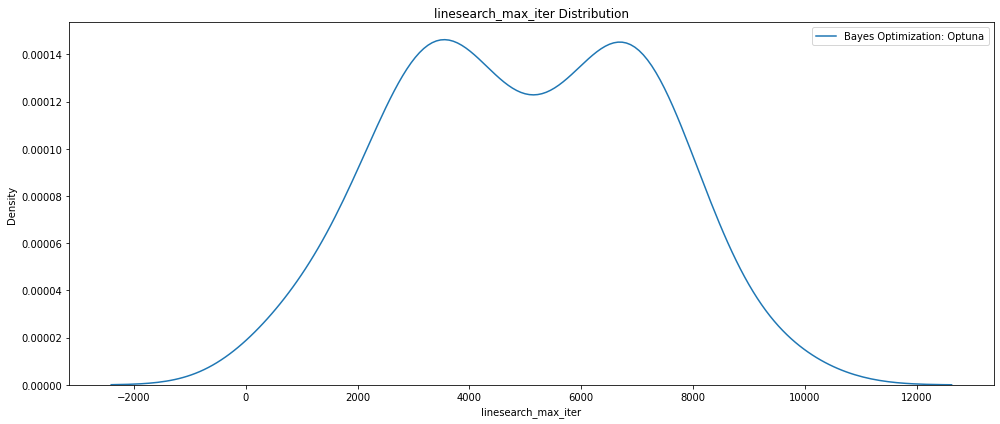

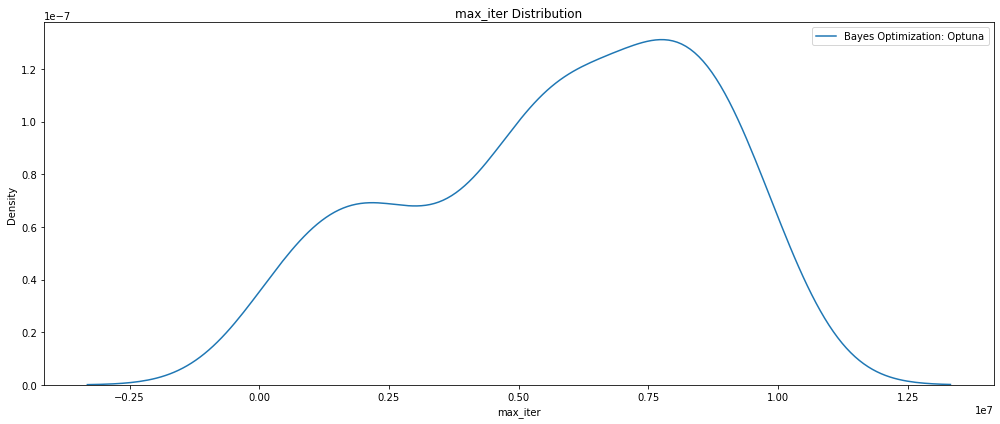

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

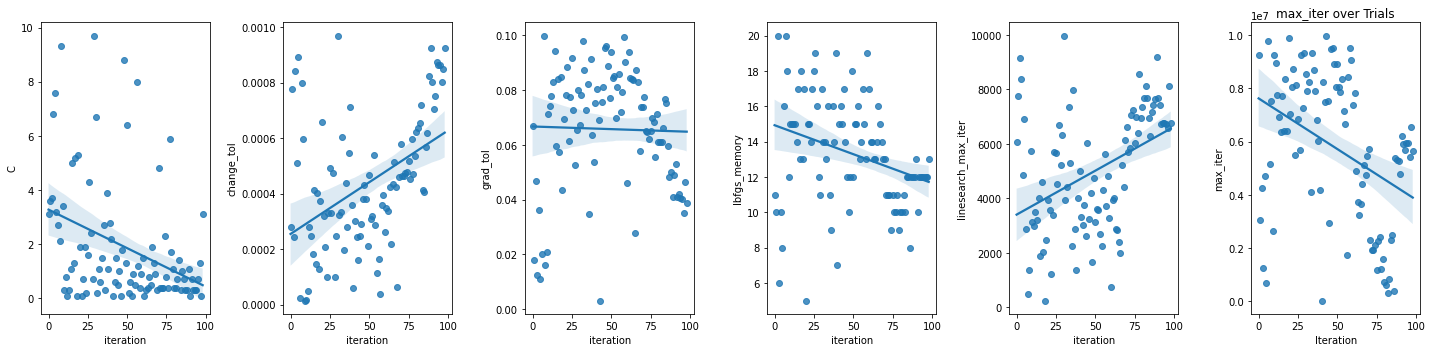

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 6, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 0.30000000000000004,
 'change_tol': 1.6018020857132863e-05,
 'grad_tol': 0.07114383111807446,
 'lbfgs_memory': 15,
 'linesearch_max_iter': 3129,
 'loss': 'hinge',
 'max_iter': 9243774,
 'penalized_intercept': 'False',
 'penalty': 'l1'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_SMOTE_trials100_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_SMOTE_trials100_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

[W] [21:12:48.455419] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


In [ ]:
print('\nModel Metrics for LinearSVC HPO SMOTE 100 trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO SMOTE 100 trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.84      0.84      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.91      0.91      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[369054   8794]
 [  8505  46120]]


Accuracy score : 0.960
Precision score : 0.840
Recall score : 0.844
F1 score : 0.842


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 ROCweighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 ROCweighted GPU trials optimization scores 0.91051 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      10
roc_weighted                             0.910482
datetime_start         2022-06-28 21:09:54.517042
datetime_complete      2022-06-28 21:10:15.364152
duration                   0 days 00:00:20.847110
C                                             0.3
change_tol                               0.000016
grad_tol                                 0.071144
lbfgs_memory                                 15.0
linesearch_max_iter                        3129.0
loss                                        hinge
max_iter                                9243774.0
penalized_intercept                         False
penatly                                        l1
state                                    COMPLETE
Name: 10, dtype: object


In [12]:
################################################################################
######################            Recall           #############################
######################         100 Trials          #############################
################################################################################
# Define a name for the trials
study_name = 'dask_linearSVC_optuna_SMOTE_100_recall_tpe'

In [13]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [14]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LinearSVC(penalty=penalty, 
                   loss=loss, 
                   penalized_intercept=penalized_intercept, 
                   max_iter=max_iter, 
                   linesearch_max_iter=linesearch_max_iter, 
                   lbfgs_memory=lbfgs_memory, 
                   C=C, 
                   grad_tol=grad_tol, 
                   change_tol=change_tol,  
                   verbose=False)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = recall_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Recall:', score)
    print('######################################################')

    return score

In [15]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

[W] [22:33:19.425402] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
- Trial time: 2.5214960679998057
- Trial Recall: 0.9193592677345538
######################################################
Score with default parameters :  0.9193592677345538


In [16]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_SMOTE_100_GPU_Recall.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)

    return score

In [17]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_SMOTE_100_GPU_Recall.pkl'): 
      study = joblib.load('LinearSVC_Optuna_SMOTE_100_GPU_Recall.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-28 22:33:19.847494
[W] [22:33:20.172311] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.42013464299998304
- Trial Recall: 0.0
######################################################
[W] [22:33:20.836161] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.4212984729999789
- Trial Recall: 0.0
######################################################
[W] [22:33:21.511003] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.47316232299999683
- Trial Recall: 0.0
######################################################
- Trial time: 1.0880082490000405
- Trial Recall: 0.9193592677345538
######################################################
- Trial time: 1.4928464869999516
- Trial Recall: 0.7382700228832952
######################################################
[W] [22:33:25.277479] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.4363

In [18]:
study = joblib.load('LinearSVC_Optuna_SMOTE_100_GPU_Recall.pkl')

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Number of finished trials: 100
Best trial: {'penalty': 'l1', 'loss': 'squared_hinge', 'penalized_intercept': 'False', 'max_iter': 4482062, 'linesearch_max_iter': 5910, 'lbfgs_memory': 8, 'C': 0.4, 'grad_tol': 0.002400303615336651, 'change_tol': 0.00015401399095106092}
Highest F1 Score 0.9193592677345538


In [19]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions


In [20]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol':'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol':'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory':'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_loss':'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept':'penalized_intercept'}, inplace=True)
trials_df.rename(columns={'params_penalty':'penatly'}, inplace=True)

trials_df = trials_df.sort_values('recall', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVC_Optuna_SMOTE_100_GPU_Recall.csv', index=False)

    iteration    recall             datetime_start          datetime_complete  \
49         49  0.919359 2022-06-28 22:34:15.801265 2022-06-28 22:34:17.383422   
73         73  0.919359 2022-06-28 22:34:45.645775 2022-06-28 22:34:47.025270   
71         71  0.919359 2022-06-28 22:34:42.957044 2022-06-28 22:34:44.570164   
69         69  0.919359 2022-06-28 22:34:40.466733 2022-06-28 22:34:41.658487   
68         68  0.919359 2022-06-28 22:34:39.181116 2022-06-28 22:34:40.466574   
..        ...       ...                        ...                        ...   
77         77  0.000000 2022-06-28 22:34:50.776421 2022-06-28 22:34:51.413321   
34         34  0.000000 2022-06-28 22:33:58.986517 2022-06-28 22:33:59.612462   
26         26  0.000000 2022-06-28 22:33:50.283972 2022-06-28 22:33:50.888639   
0           0  0.000000 2022-06-28 22:33:19.853966 2022-06-28 22:33:20.475725   
99         99       NaN 2022-06-28 22:35:17.786125                        NaT   

                 duration  

In [21]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations


In [22]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [23]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [24]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_LinearSVC_100_GPU_Recall.html')
fig.show()

In [25]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

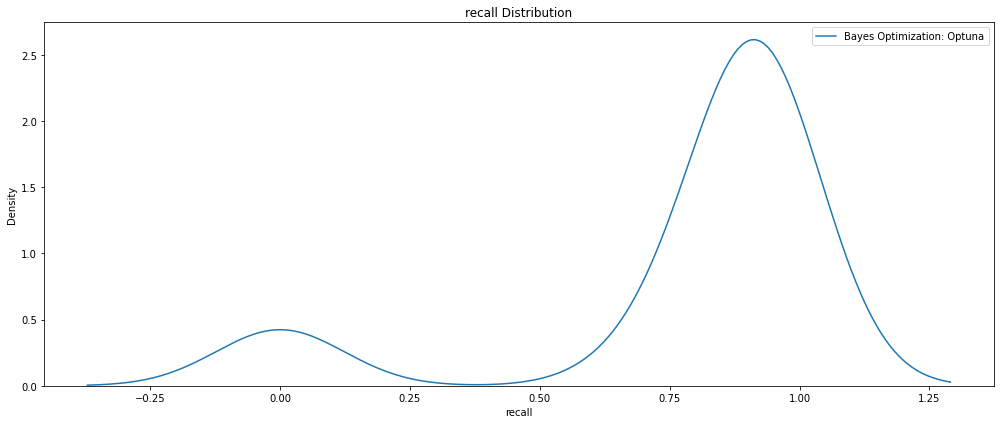

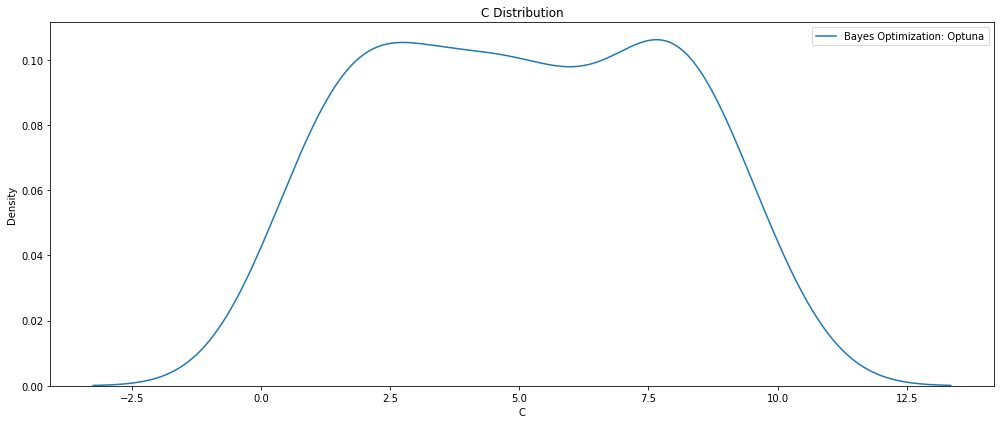

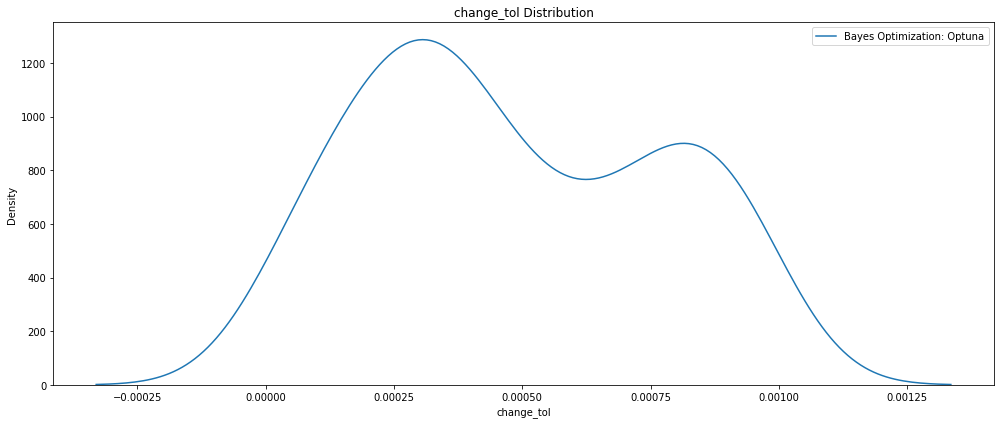

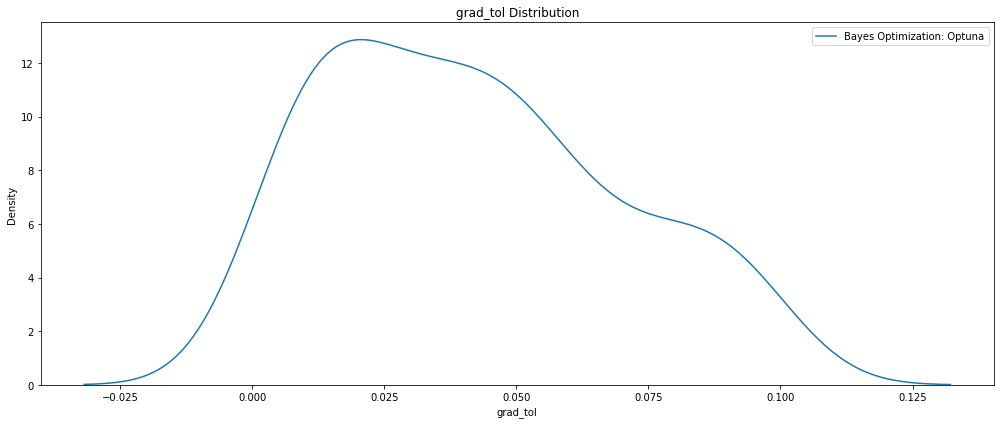

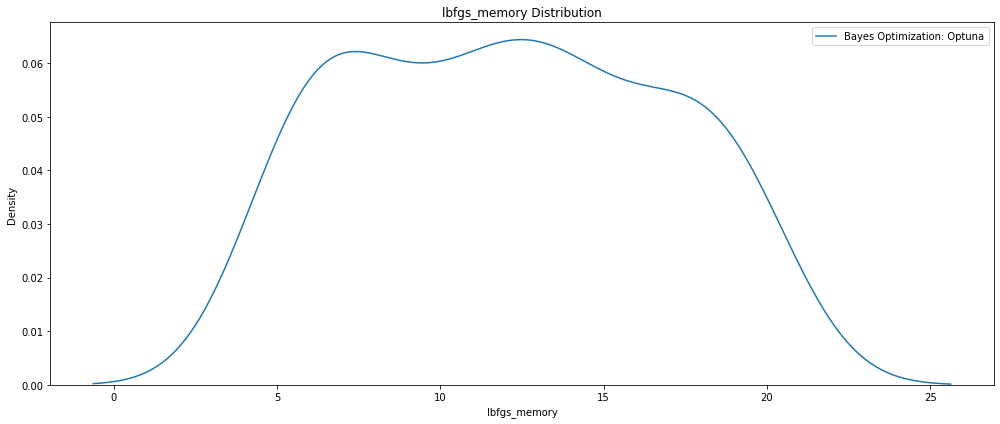

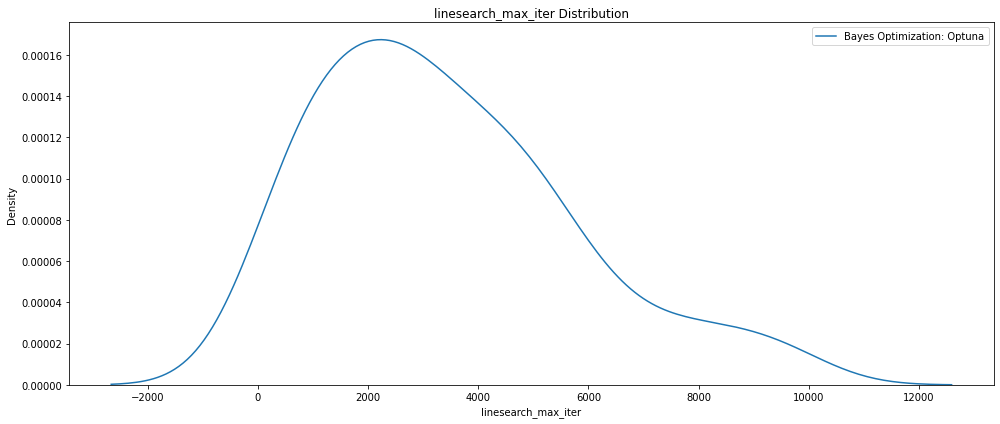

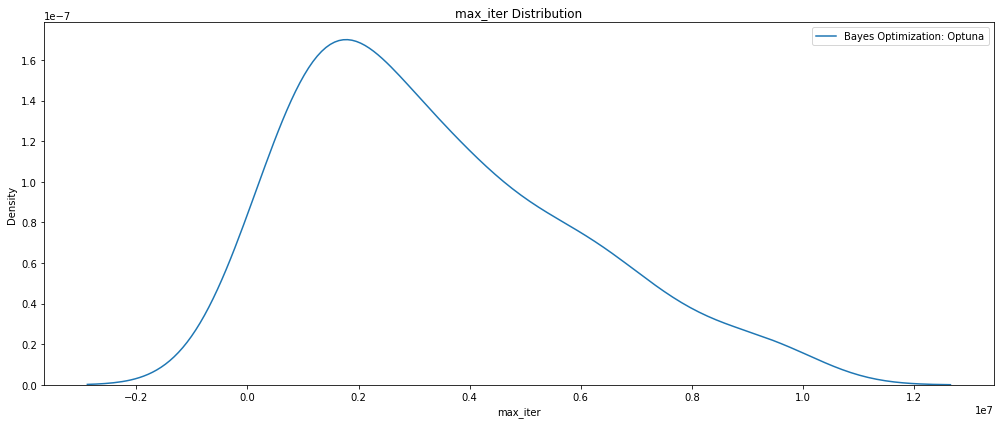

In [26]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: #'epsilon', 
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

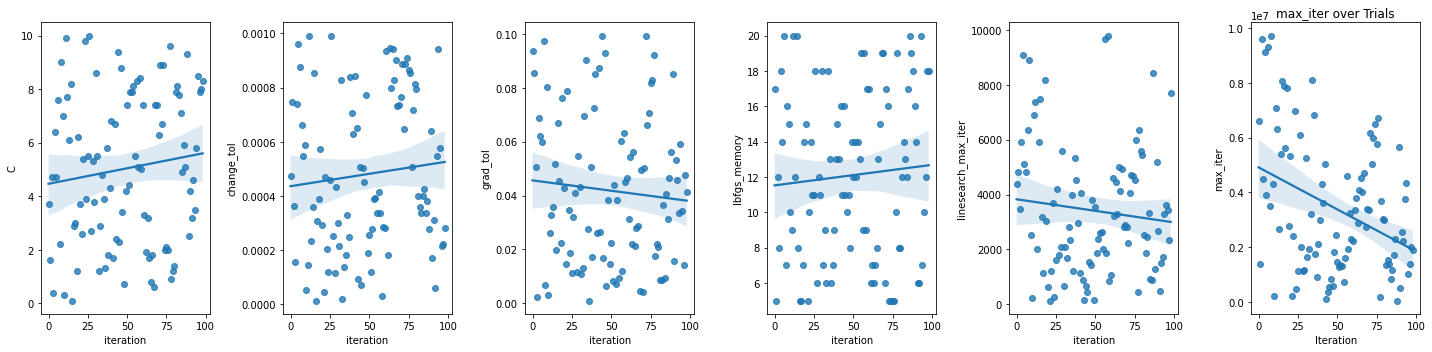

In [27]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 6, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [28]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations


In [29]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [30]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [31]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 0.4,
 'change_tol': 0.00015401399095106092,
 'grad_tol': 0.002400303615336651,
 'lbfgs_memory': 8,
 'linesearch_max_iter': 5910,
 'loss': 'squared_hinge',
 'max_iter': 4482062,
 'penalized_intercept': 'False',
 'penalty': 'l1'}

In [32]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [33]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [34]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [35]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [36]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_SMOTE_trials100_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_SMOTE_trials100_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [37]:
print('\nModel Metrics for LinearSVC HPO SMOTE 100 trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO SMOTE 100 trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    377848
           1       0.35      0.92      0.51     54625

    accuracy                           0.77    432473
   macro avg       0.67      0.84      0.68    432473
weighted avg       0.90      0.77      0.81    432473



Confusion matrix:
[[284615  93233]
 [  4405  50220]]


Accuracy score : 0.774
Precision score : 0.350
Recall score : 0.919
F1 score : 0.507


In [38]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 Recall GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 Recall GPU trials optimization scores 0.83631 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      49
recall                                   0.919359
datetime_start         2022-06-28 22:34:15.801265
datetime_complete      2022-06-28 22:34:17.383422
duration                   0 days 00:00:01.582157
C                                             4.2
change_tol                                0.00019
grad_tol                                 0.014522
lbfgs_memory                                 14.0
linesearch_max_iter                         148.0
loss                                squared_hinge
max_iter                                2447829.0
penalized_intercept                         False
penatly                                        l1
state                                    COMPLETE
Name: 49, dtype: object


In [ ]:
################################################################################
######################          Precision          #############################
######################         100 Trials          #############################
################################################################################
# Define a name for the trials
study_name = 'dask_linearSVC_optuna_SMOTE_100_precision_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LinearSVC(penalty=penalty, 
                   loss=loss, 
                   penalized_intercept=penalized_intercept, 
                   max_iter=max_iter, 
                   linesearch_max_iter=linesearch_max_iter, 
                   lbfgs_memory=lbfgs_memory, 
                   C=C, 
                   grad_tol=grad_tol, 
                   change_tol=change_tol,  
                   verbose=False)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = precision_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Precision:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 1.582503781000014
- Trial Precision: 0.35007981708294705
######################################################
Score with default parameters :  0.35007981708294705


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_SMOTE_100_GPU_Precision.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)
    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_SMOTE_100_GPU_Precision.pkl'): 
      study = joblib.load('LinearSVC_Optuna_SMOTE_100_GPU_Precision.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-28 21:17:56.089946
[W] [21:17:56.382242] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.40256519500007926
- Trial Precision: 0.0
######################################################
[W] [21:17:56.911611] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.3902960020000137
- Trial Precision: 0.0
######################################################
[W] [21:17:57.433179] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.382685132000006
- Trial Precision: 0.0
######################################################
[W] [21:17:57.953578] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.38410682399990037
- Trial Precision: 0.0
######################################################
- Trial time: 1.6201301850001073
- Trial Precision: 0.6393559531544667
######################################################
[W] [21:18:00.239859]

In [ ]:
study = joblib.load('LinearSVC_Optuna_SMOTE_100_GPU_Precision.pkl')

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Number of finished trials: 100
Best trial: {'penalty': 'l1', 'loss': 'hinge', 'penalized_intercept': 'True', 'max_iter': 7952421, 'linesearch_max_iter': 4514, 'lbfgs_memory': 18, 'C': 0.9, 'grad_tol': 0.015994652489638973, 'change_tol': 0.00031183796371566806}
Highest F1 Score 0.8808547327212565


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol':'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol':'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory':'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_loss':'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept':'penalized_intercept'}, inplace=True)
trials_df.rename(columns={'params_penalty':'penatly'}, inplace=True)

trials_df = trials_df.sort_values('precision', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVC_Optuna_SMOTE_100_GPU_Precision.csv', index=False)

    iteration  precision             datetime_start  \
70         70   0.880855 2022-06-28 21:19:36.322773   
83         83   0.880855 2022-06-28 21:19:58.411907   
67         67   0.880855 2022-06-28 21:19:31.964414   
71         71   0.880855 2022-06-28 21:19:38.075302   
72         72   0.880855 2022-06-28 21:19:39.927314   
..        ...        ...                        ...   
7           7   0.000000 2022-06-28 21:18:01.014643   
8           8   0.000000 2022-06-28 21:18:01.518936   
57         57   0.000000 2022-06-28 21:19:15.874818   
0           0   0.000000 2022-06-28 21:17:56.091316   
99         99        NaN 2022-06-28 21:20:25.085555   

            datetime_complete               duration    C  change_tol  \
70 2022-06-28 21:19:38.075166 0 days 00:00:01.752393  0.9    0.000263   
83 2022-06-28 21:20:00.478789 0 days 00:00:02.066882  0.9    0.000407   
67 2022-06-28 21:19:33.620366 0 days 00:00:01.655952  0.9    0.000308   
71 2022-06-28 21:19:39.927181 0 days 00:00:01.8

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_LinearSVC_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

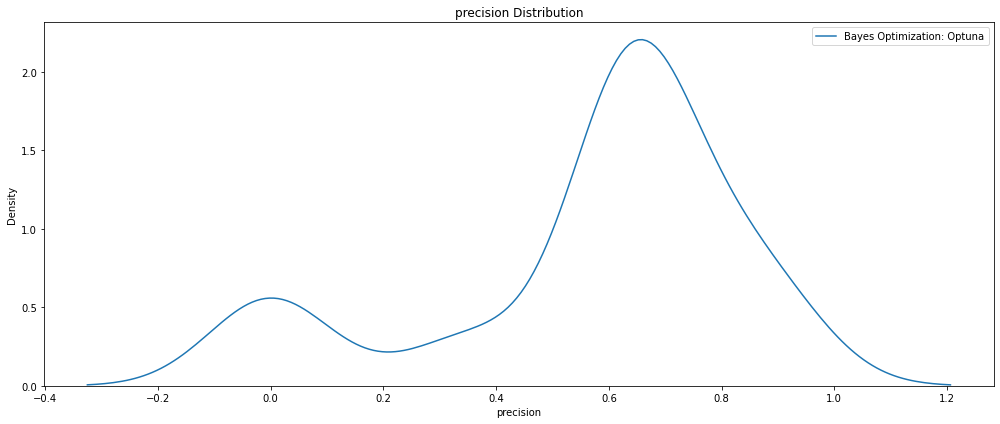

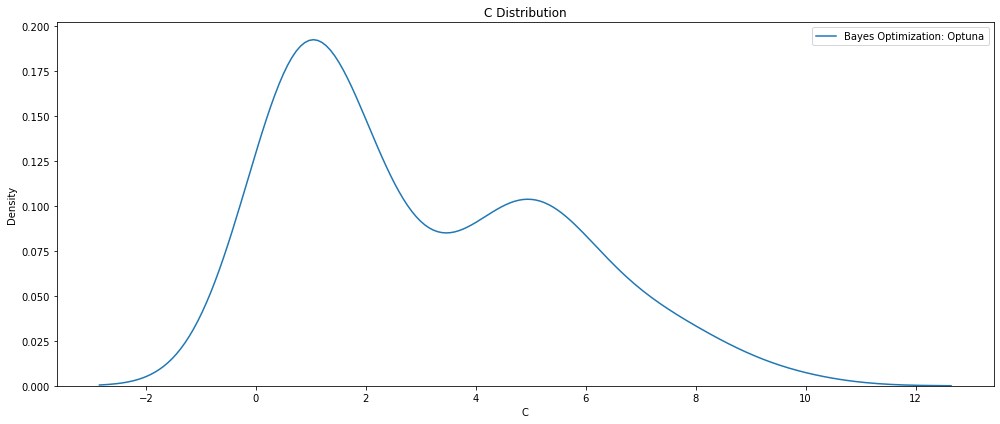

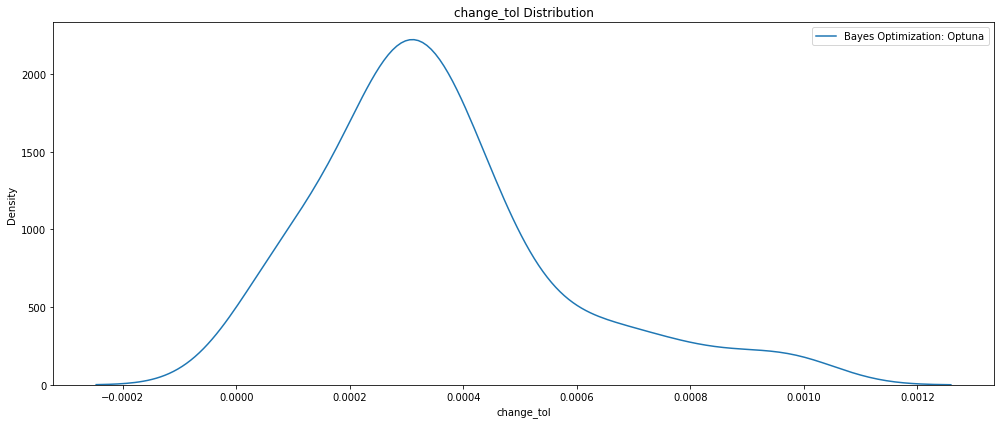

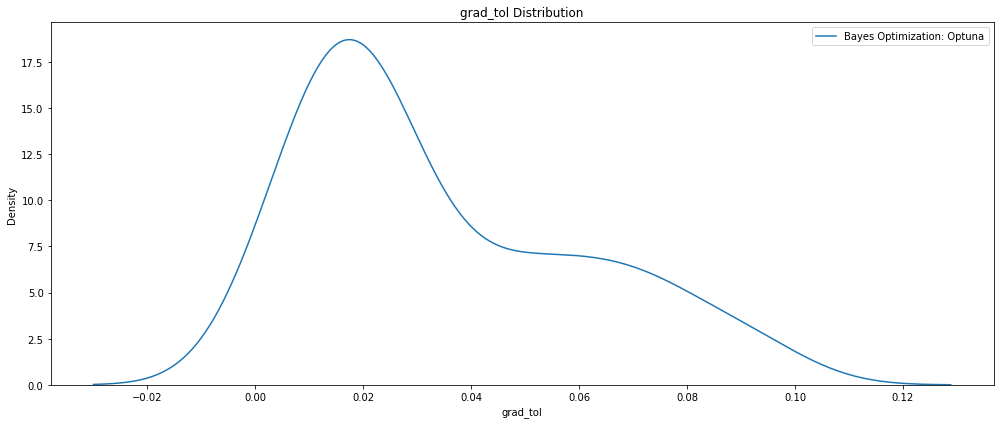

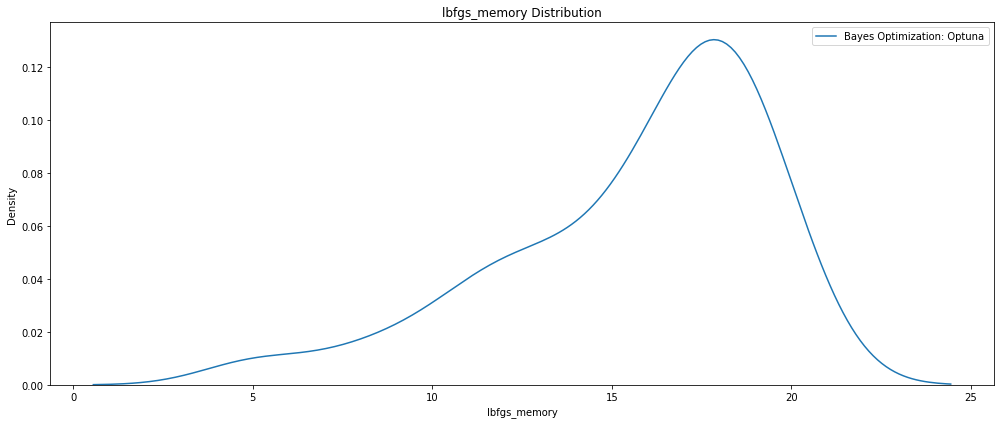

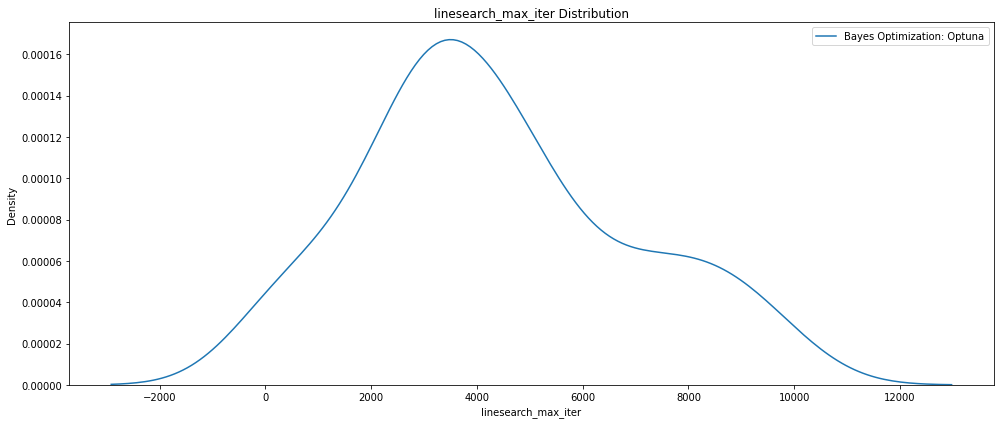

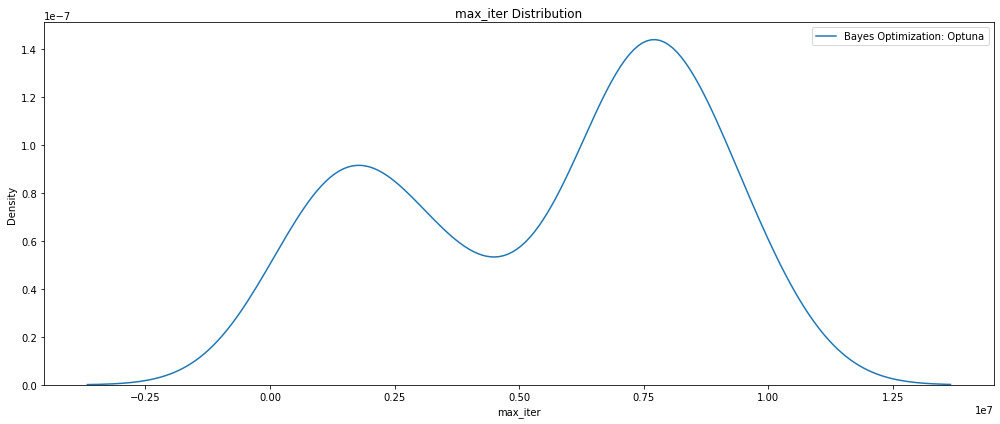

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: #'epsilon', 
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

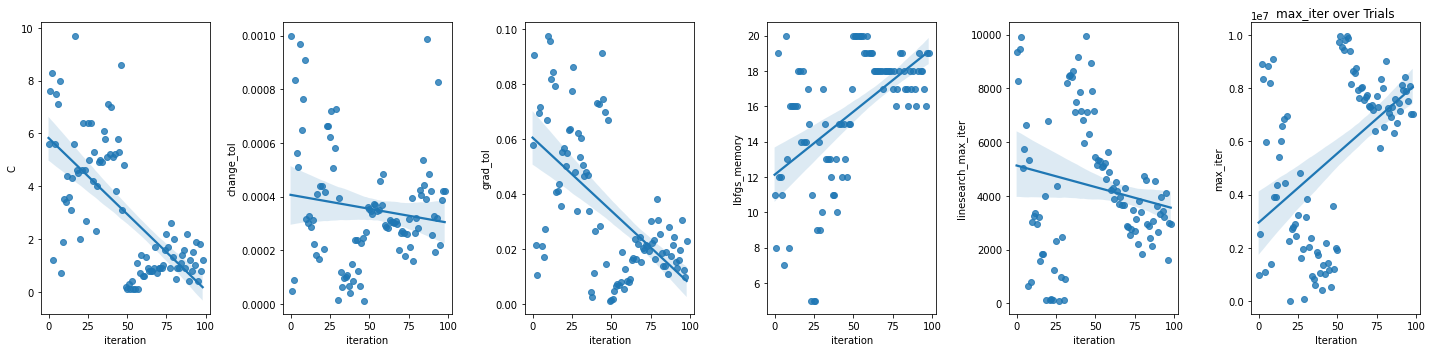

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 6, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 0.9,
 'change_tol': 0.00031183796371566806,
 'grad_tol': 0.015994652489638973,
 'lbfgs_memory': 18,
 'linesearch_max_iter': 4514,
 'loss': 'hinge',
 'max_iter': 7952421,
 'penalized_intercept': 'True',
 'penalty': 'l1'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_SMOTE_trials100_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_SMOTE_trials100_GPU_Precision.pkl')
# print(model)
# =============================================================================

[W] [21:20:37.674603] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


In [ ]:
print('\nModel Metrics for LinearSVC HPO SMOTE 100 trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO SMOTE 100 trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    377848
           1       0.88      0.69      0.78     54625

    accuracy                           0.95    432473
   macro avg       0.92      0.84      0.87    432473
weighted avg       0.95      0.95      0.95    432473



Confusion matrix:
[[372735   5113]
 [ 16824  37801]]


Accuracy score : 0.949
Precision score : 0.881
Recall score : 0.692
F1 score : 0.775


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 Precision GPU trials optimization scores 0.83924 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      70
precision                                0.880855
datetime_start         2022-06-28 21:19:36.322773
datetime_complete      2022-06-28 21:19:38.075166
duration                   0 days 00:00:01.752393
C                                             0.9
change_tol                               0.000263
grad_tol                                 0.020394
lbfgs_memory                                 18.0
linesearch_max_iter                        2865.0
loss                                        hinge
max_iter                                7339581.0
penalized_intercept                          True
penatly                                        l1
state                                    COMPLETE
Name: 70, dtype: object
